In [1]:
from pathlib import Path

%matplotlib widget 
import matplotlib.pyplot as plt

import lightkurve as lk

from utility import iterate_targets
from utility import echo_analysis_log, parse_analysis_for_eclipses
from utility import flatten_lightcurve, plot_lightcurves_and_mask
from utility import calculate_variability_metric, lookup_tess_ebs_ephemeris

In [2]:
# The following are good for clear primary & secondary eclipses and detrending through flattening;
# TIC141685465, TIC167692429, TIC307488184. TIC355152640, TIC382517745, TIC260132330

# TIC300560295 shows flattening removing pulsations but the secondary is not clear

# TIC308851582 looks like the analysis hasn't picked up the secondary correctly
# TIC341193555 - wrong secondary eclipse

# TIC350518984 has zero eclipse widths - also cannot see a secondary
# TIC372909935 has zero eclipse widths

# TIC031273263 - look into where the secondary is

# TIC309658221 - noisy but analysis should work

# TIC140659980 has good eclipses and potentially interesting residuals

# TIC167692429 - some variability in eclipse timings 
target = "TIC255567460"
flux_column = "pdcsap_flux"
quality_bitmask = "default"
sectors = []
eclipse_dur_multiple = 1.

input_file = Path(".") / "tessebs_extra.csv"
catalogue_dir = Path(".") / "catalogue"
analysis_dir = catalogue_dir / "analysis"
analysis_dir.mkdir(parents=True, exist_ok=True)

Analysis Log:
2024-03-16 10:23:57 INFO main_functions - analyse_light_curve: Start of analysis
2024-03-16 10:33:21 INFO main_functions - analyse_frequencies: Frequency extraction done. Total time elapsed: 564.1s.
2024-03-16 10:36:54 INFO main_functions - analyse_harmonics: Harmonic analysis done. Total time elapsed: 212.6s.
2024-03-16 10:36:59 INFO main_functions - analyse_light_curve: Dividing period by 2, redoing some steps
2024-03-16 10:40:16 INFO main_functions - analyse_harmonics: Harmonic analysis done. Total time elapsed: 196.3s.
2024-03-16 10:40:24 INFO main_functions - find_eclipse_timings: One of the eclipses too shallow, depths: 0.01060633946350751, 0.0012989644549689506, err: 0.00018473227284815377, 0.00029775948730785935, noise level: 0.0038594040554662057
2024-03-16 10:40:24 INFO main_functions - analyse_light_curve: End of analysis. Total time elapsed: 987.4s.
From 255567460_analysis_summary.csv
Reference time:              -1.000000+/-0
Orbital period:              6.89

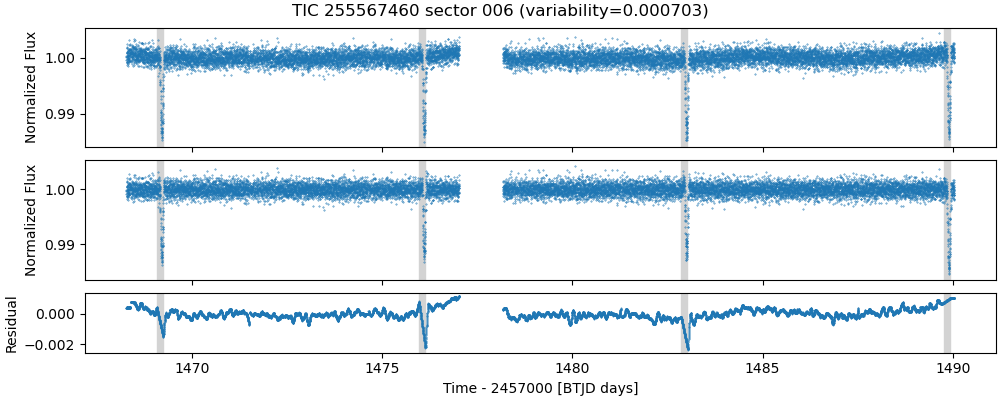


Processing sector 007 pdcsap_flux...flattening the light curve...plotting the lightcurves.


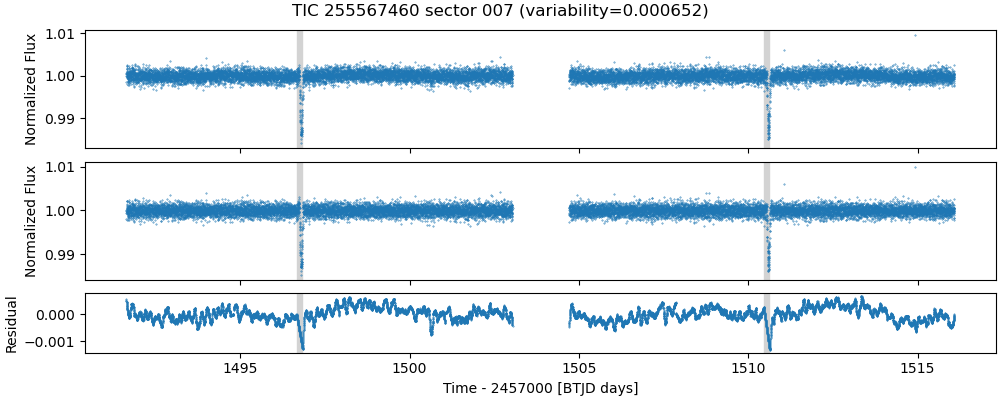


Processing sector 012 pdcsap_flux...flattening the light curve...plotting the lightcurves.


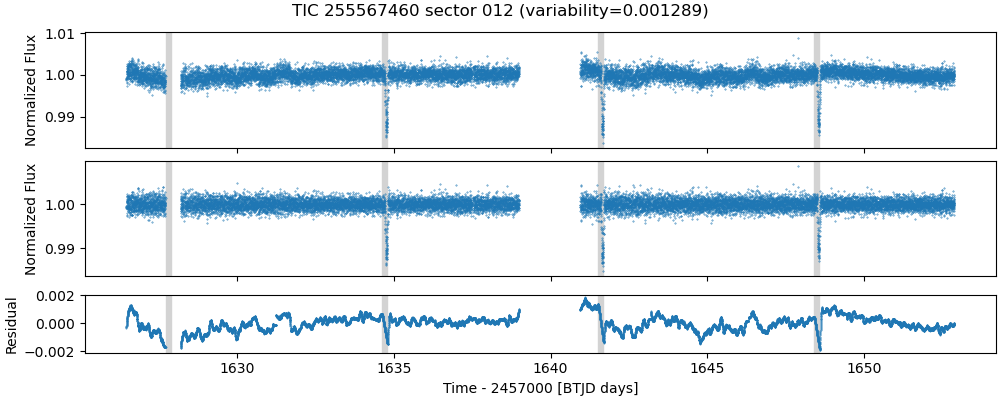


Processing sector 061 pdcsap_flux...flattening the light curve...plotting the lightcurves.


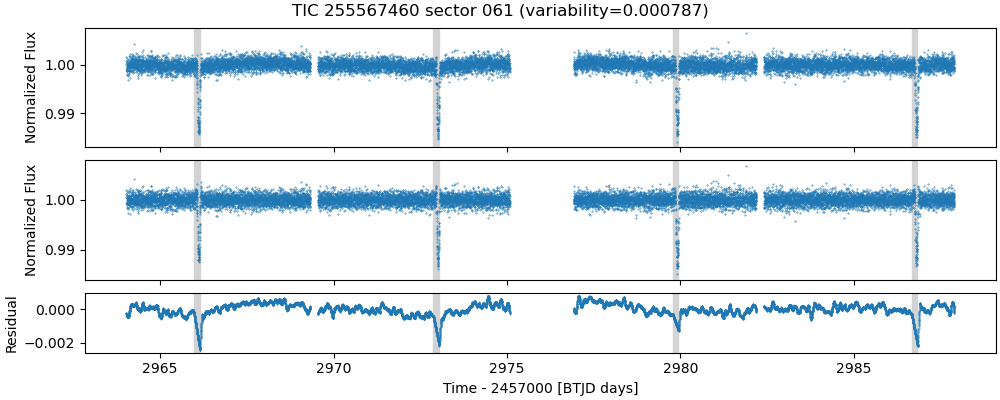


Processing sector 062 pdcsap_flux...flattening the light curve...plotting the lightcurves.


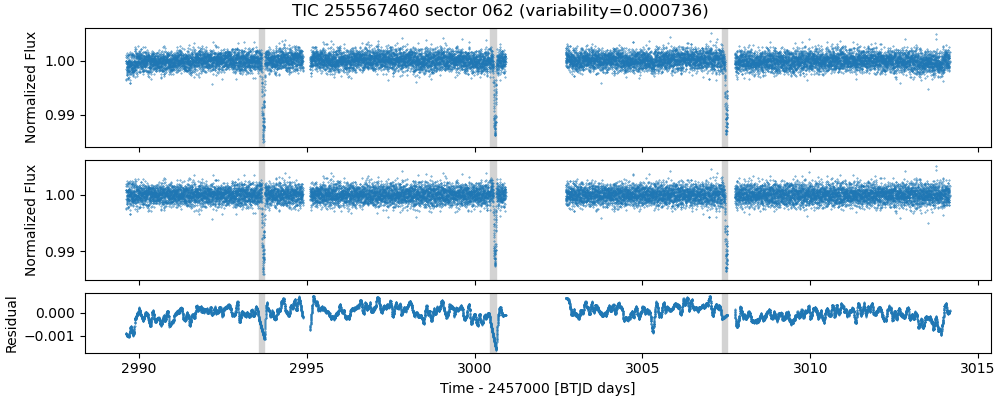


Processing sector 065 pdcsap_flux...flattening the light curve...plotting the lightcurves.


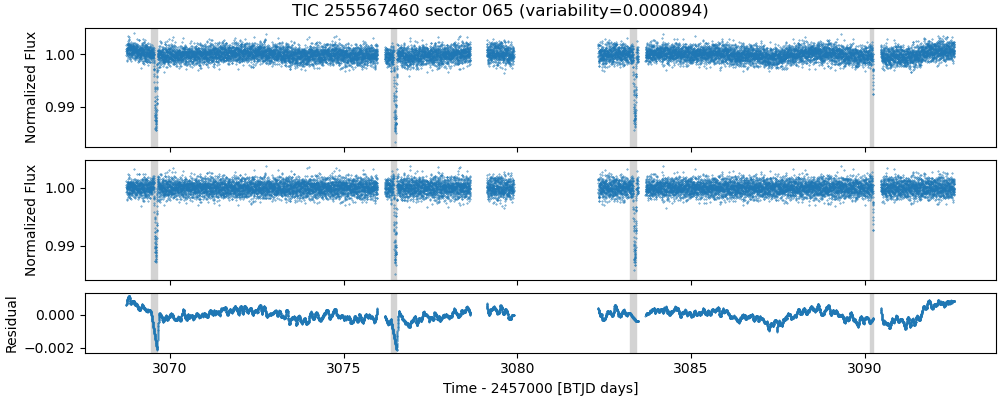


Processing sector 066 pdcsap_flux...flattening the light curve...plotting the lightcurves.


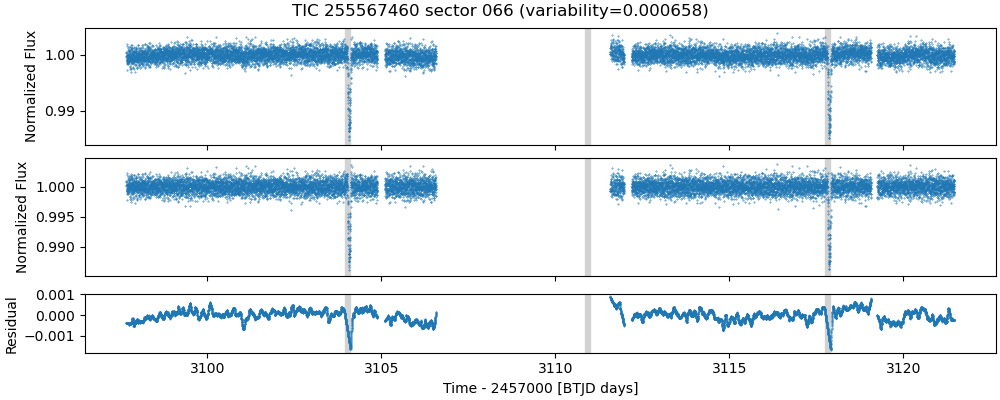


Processing sector 068 pdcsap_flux...flattening the light curve...plotting the lightcurves.


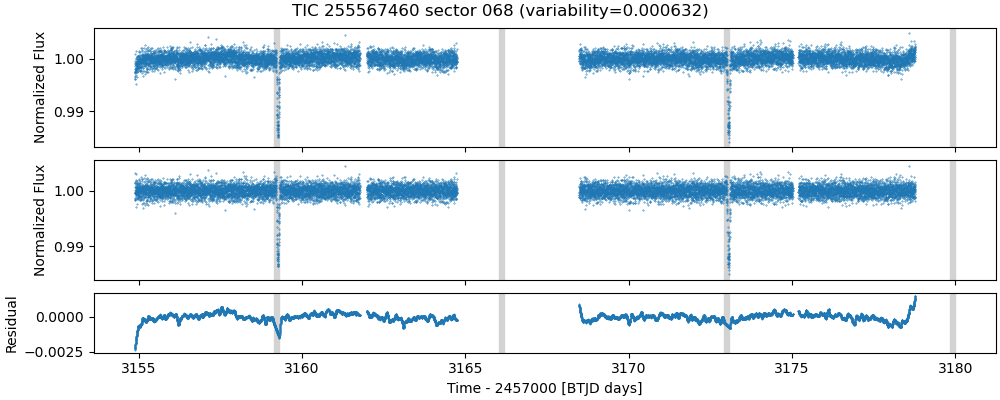


Processing sector 069 pdcsap_flux...flattening the light curve...plotting the lightcurves.


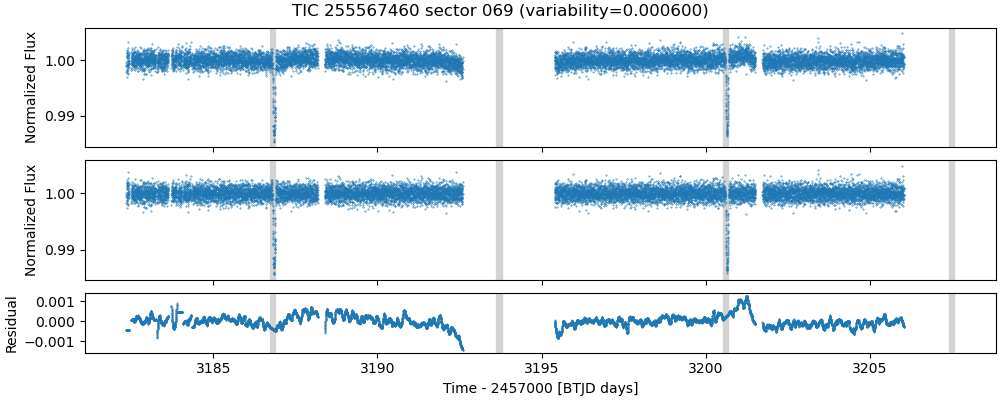

In [6]:
# Get the target's basic details. StopIteration will be raised if the target is unknown
target, target_row, _ = next(iterate_targets(input_file, index_filter=[target]))
tic = target_row["TIC"]

# We need the analysis output, as that contains the eclipse timing data
analysis_csv = analysis_dir / f"{tic}_analysis" / f"{tic}_analysis_summary.csv"
echo_analysis_log(analysis_csv.parent / f"{tic}.log")
eclipses = parse_analysis_for_eclipses(analysis_csv, duration_scale=eclipse_dur_multiple)
if not eclipses:
    print(f"Did not find '{analysis_csv}'. Unable to process {target}. Skipping.")
else:
    (t0, period, ecl_times, ecl_durs) = eclipses
    if t0 is None or t0 <= 0.:
        print("Analysis didn't give a reference time so querying TESS-ebs for one")
        t0, _ = lookup_tess_ebs_ephemeris(target, tic)
        if t0:
            print(f"Using reference time from TESS-ebs of {t0:.6f} for eclipse timings.")
            ecl_times = [et + t0 for et in ecl_times]

    # Load, filter and then process the requested sectors for this target.
    download_dir = catalogue_dir / f"download/{tic}/"
    fits = sorted(download_dir.rglob("**/*.fits"))
    lcs = lk.LightCurveCollection([
        lk.read(f"{f}", flux_column=flux_column, quality_bitmask=quality_bitmask) for f in fits])

    print(f"Loaded {len(lcs)} light curve fits file(s) for {target}.")
    for lc in [l for l in lcs if len(sectors) == 0 or l.sector in sectors]:
        print(f"\nProcessing sector {lc.sector:03d} {flux_column}...", end="")

        # Process the light curve
        print("flattening the light curve...", end="")
        lc = lc.normalize()
        flat_lc, res_lc, ecl_mask = flatten_lightcurve(lc, ecl_times, ecl_durs, period)
        variability = calculate_variability_metric(res_lc)

        # Plots
        print("plotting the lightcurves.")
        title = f"{lc.meta['OBJECT']} sector {lc.sector:03d} (variability={variability:.6f})"
        fig, _ = plot_lightcurves_and_mask(lc, flat_lc, res_lc, ecl_mask, (10, 4), title)
        plt.show(block=False)